##  Unsupervised Learning Series

#  Part 2:  K-means clustering

The subject of this post is another archetypal unsupervised learning problem: *clustering*. In simple terms, clustering refers to identifying clusters (or groups) of similar data points within a dataset. Generally speaking, clustering is done for one of two reasons: (a) as a pre-processing step and to reduce the dimensionality of very large datasets, or (b) to uncover underlying group structures in data. 

As a data reduction scheme, clustering transforms a dataset with a large number of data points into a union of relatively small number of clusters. By representing all members of each cluster by that cluster's representative, we can significantly reduce the computational cost of applying complex machine learning algorithms to very large datasets. Uncovering and understanding existing underlying structures in data is another reason to perform clustering. For example, various clustering methods have been applied in the field of Bioinformatics to help simplify genetic data for human interpretation
[[1]](#endnotes),[[2]](#endnotes). While geneticists currently do have a good understanding of cellular functionalities of many genes across the human genome, the functionality of some remain a mystery. Clustering gene expression data into groups of 'similar' genes then helps shine a light on potential functionality of the obscure genes by associating them with the well-studied ones within the same cluster.

Depending on how we define and model similarity between groups of data points, we arrive at various clustering modes (e.g., data-clustering or graph-clustering) and methods (e.g., K-means, spectral clustering, etc.). In this post we begin our discussion of clustering by studying K-means, the most fundamental data-clustering method that - interestingly - is closely related to Principal Component Analysis (PCA).

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import autograd.numpy as np
import math
import pandas as pd
%matplotlib inline

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

from sklearn import datasets
from IPython import display
from mlrefined_libraries import unsupervised_library as unsuperlearnlib

%load_ext autoreload
%autoreload 2

# 1. K-means clustering

With K-means clustering we reduce the data dimension by finding suitable representatives or centroids for clusters, or groups, of data points. All members of each cluster are then represented by their cluster's respective centroid. Hence the problem of clustering is that of partitioning data into clusters of points with similar characteristics, and with K-means specifically this characteristic is geometric closeness in the feature space.

The figure below illustrates K-means clustering performed on a 2-D toy dataset with $P = 10$ data points, where in the right panel data points are clustered into $K = 3$ clusters.

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/Fig_9_2.png' width="75%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> (left) A 2-D toy dataset with $P=10$ data points. (right) Original data clustered into $K=3$ clusters where each cluster centroid is marked by a '$\times$' symbol. Points that are geometrically close to one another belong to the same cluster. </em>  </figcaption> 
</figure>

## 1.1 Notation and modeling

With K-means we look to partition $P$ data points each of dimension $N$, into $K$ clusters and find a representative centroid denoted for each cluster. For the moment we will assume that we know the location of these $K$ cluster centroids, as illustrated figuratively in the toy example in the right panel of Figure 1, in order to derive formally the desired relationship between the data and centroids. Once this is expressed clearly we will use it in order to form a learning problem for the accurate recovery of cluster centroids, dropping the unrealistic notion that we have pre-conceived knowledge of their location. 

Denoting by $\mathbf{c}_{k}$ the centroid of the $k^{th}$ cluster and $\mathcal{S}_{k}$ the set of indices of the subset of those $P$ data points, denoted $\mathbf{x}_{1}, \dots, \mathbf{x}_{P}$, belonging to this cluster the desire that points in the $k^{th}$ cluster should lie close to its centroid may be written mathematically as

\begin{equation}
\mathbf{c}_{k}\approx\mathbf{x}_{p}\quad\textrm{for all }p\in\mathcal{S}_{k}
\end{equation}

for all $k=1, \ldots, K$. These desired relations can be written more conveniently by first stacking the centroids column-wise into the *centroid matrix* 

\begin{equation}
\mathbf{C}=\left[\begin{array}{cccc}
\mathbf{c}_{1} & \mathbf{c}_{2} & \cdots & \mathbf{c}_{K}\end{array}\right]
\end{equation}

Then, denoting by $\mathbf{e}_{k}$ the $k^{th}$ standard basis vector (that is a $K\times1$ vector with a $1$ in the $k^{th}$ slot and zeros elsewhere) we may write $\mathbf{c}_{k}$ as $\mathbf{C}\,\mathbf{e}_{k}$, and hence the relations in equation (1) may be written equivalently for each $k$ as

\begin{equation}
\mathbf{C} \, \mathbf{e}_{k}\approx\mathbf{x}_{p}\quad\textrm{for all }p\in\mathcal{S}_{k}
\end{equation}

Next, to write these equations even more conveniently we stack the data column-wise into the data matrix

\begin{equation}
\mathbf{X}=\left[\begin{array}{cccc}
\mathbf{x}_{1} & \mathbf{x}_{2} & \cdots & \mathbf{x}_{P}\end{array}\right]
\end{equation}

and form a $K\times P$ *assignment matrix* $\mathbf{W}$. The $p^{th}$ column of this matrix, denoted as $\mathbf{w}_{p}$, is the standard basis vector associated with the cluster to which the $p^{th}$ point belongs, i.e., $\mathbf{w}_{p}=\mathbf{e}_{k}$ if $p\in\mathcal{S}_{k}$. With this $\mathbf{w}_{p}$ notation we may write each equation in (3) as $\mathbf{C}\mathbf{w}_{p}\approx\mathbf{x}_{p}$ for all $p\in\mathcal{S}_{k}$, or using matrix notation all $K$ such relations simultaneously as

\begin{equation}
\mathbf{CW}\approx\mathbf{X}
\end{equation}

Figure 2 pictorially illustrates the compactly written desired K-means relationship in (5) for the dataset shown in Figure 1. Note that the location of the only nonzero entry in each column of the assignment matrix $\mathbf{W}$ determines the cluster membership of its corresponding data point in $\mathbf{X}$.

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/Fig_9_3.png' width="75%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> <em> K-means clustering relations described in a compact matrix form. Cluster centroids in $C$ lie close to their corresponding cluster points in $X$. The $p^{th}$ column of the assignment matrix $W$ contains the standard basis vector corresponding to the data point's cluster centroid. </em>  </figcaption> 
</figure>

We may now drop the assumption that we know the locations of cluster centroids and the knowledge of which points are assigned to them, i.e., the exact description of the centroid matrix $\mathbf{C}$ and assignment matrix $\mathbf{W}$. We want to *learn* the right values for these two matrices. Specifically, we know that the ideal $\mathbf{C}$ and $\mathbf{W}$ satisfy the compact relations described in equation (5), i.e., that $\mathbf{C}\mathbf{W}\approx\mathbf{X}$ or in other words that $\left\Vert \mathbf{C}\mathbf{W}-\mathbf{X}\right\Vert _{F}^{2}$ is small, while $\mathbf{W}$ consists of properly chosen standard basis vectors relating the data points to their respective centroids. Thus we phrase a K-means optimization problem whose solution precisely satisfies these requirements as

\begin{equation}
\begin{aligned}\underset{\mathbf{C},\mathbf{W}}{\mbox{minimize}} & \,\,\left\Vert \mathbf{CW}-\mathbf{X}\right\Vert _{F}^{2}\\
\mbox{subject to} & \,\,\,\,\,\mathbf{w}_{p}\in\left\{ \mathbf{e}_{k}\right\} _{k=1}^{K},\,\,\, p=1,\ldots,P
\end{aligned}
\end{equation}

Notice, how the K-means problem given in equation (6) is - structurally - just a matrix factorization problem like PCA with additional set of constraints on the weight matrix. 

## 1.2 Optimization of the K-means problem

Akin to PCA, the K-means' objective is non-convex, and because we cannot minimize over both $\mathbf{C}$ and $\mathbf{W}$ simultaneously, it is solved via alternating minimization, that is by alternately minimizing the objective function in (6) over one of the variables ($\mathbf{C}$ or $\mathbf{W}$), while keeping the other variable fixed.

Over $\mathbf{W}$ the K-means problem in (6) reduces to

\begin{equation}
\begin{aligned}\underset{\mathbf{W}}{\mbox{minimize}} & \,\,\left\Vert \mathbf{CW}-\mathbf{X}\right\Vert _{F}^{2}\\
\mbox{subject to} & \,\,\,\,\,\mathbf{w}_{p}\in\left\{ \mathbf{e}_{k}\right\} _{k=1}^{K},\,\,\, p=1,\ldots,P
\end{aligned}
\end{equation}


Noting that the objective in (7) can be equivalently written as $\sum_{p=1}^{P}\left\Vert \mathbf{Cw}_{p}-\mathbf{x}_{p}\right\Vert _{2}^{2}$ (again $\mathbf{C}$ is fixed) and that each $\mathbf{w}_{p}$ appears in only one summand, we can recover each column $\mathbf{w}_{p}$ independently by solving

\begin{equation}
\begin{aligned}\underset{\mathbf{\mathbf{w}}_{p}}{\mbox{minimize}} & \,\,\left\Vert \mathbf{Cw}_{p}-\mathbf{x}_{p}\right\Vert _{2}^{2}\\
\mbox{subject to} & \,\,\mathbf{w}_{p}\in\left\{ \mathbf{e}_{k}\right\} _{k=1}^{K}
\end{aligned}
\end{equation}

for each $p=1,\ldots,P$. 

Note that this is precisely the problem of assigning a data point $\mathbf{x}_{p}$ to its closest centroid, i.e., finding $k$ such that $\left\Vert \mathbf{c}_{k}-\mathbf{x}_{p}\right\Vert _{2}^{2}$ is smallest! We can see that this is precisely the problem above by unraveling our compact notation: given the constraint on $\mathbf{w}_{p}$, we have $\mathbf{Cw}_{p}=\mathbf{c}_{k}$ whenever $\mathbf{w}_{p}=\mathbf{e}_{k}$ and so the objective may be written as $\left\Vert \mathbf{Cw}_{p}-\mathbf{x}_{p}\right\Vert _{2}^{2}=\left\Vert \mathbf{c}_{k}-\mathbf{x}_{p}\right\Vert _{2}^{2}$. Hence the problem of finding $\mathbf{w}_{p}$, or finding the closest centroid to $\mathbf{x}_{p}$, may be written as

\begin{equation}
\begin{aligned}\underset{k=1,\dots,K}{\mbox{minimize}} & \,\,\left\Vert \mathbf{c}_{k}-\mathbf{x}_{p}\right\Vert _{2}^{2}
\end{aligned}
\end{equation}

which can be solved by simply computing the objective for each $k$ and finding the smallest value. Then for whichever $k^{\star}$ minimizes the above we may set $\mathbf{w}_{p}=\mathbf{e}_{k^{\star}}$. 

Now minimizing (6) over $\mathbf{C}$, we have no constraints (they being applied only to $\mathbf{W}$) and have the problem

\begin{equation}
\underset{\mathbf{C}}{\mbox{minimize}}\,\,\left\Vert \mathbf{CW}-\mathbf{X}\right\Vert _{F}^{2}
\end{equation}

Here we may use the first order condition: setting the derivative of $g\left(\mathbf{C}\right)=\left\Vert \mathbf{CW}-\mathbf{X}\right\Vert _{F}^{2}$ to zero gives the linear system

\begin{equation}
\mathbf{C}\mathbf{W}\mathbf{W}^{T}=\mathbf{X}\mathbf{W}^{T}
\end{equation}

for the optimal $\mathbf{C}$ denoted as $\mathbf{C}^{\star}$.

It is easy to verify that $\mathbf{W}\mathbf{W}^{T}$ is a $K\times K$ diagonal matrix whose $k^{th}$ diagonal entry is equal to the number of data points assigned to the $k^{th}$ cluster, and that the $k^{th}$ column of $\mathbf{X}\mathbf{W}^{T}$ is the sum of all data points in the $k^{th}$ cluster. Hence each column of $\mathbf{C}^{\star}$ can therefore be calculated independently as 

\begin{equation}
\mathbf{c}_{k}^{\star}=\frac{1}{\left|\mathcal{S}_{k}\right|}\underset{p\in\mathcal{S}_{k}}{\sum}\mathbf{x}_{p}\,\,\,\forall k
\end{equation}

In other words, $\mathbf{c}_{k}^{\star}$ is the average of all data points in the $k^{th}$ cluster. 

Finally, we repeat these alternating updates for a maximum number of iterations or until neither matrix changes too much from iteration to iteration. For convenience we present the resulting algorithm below.

### The K-means algorithm

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> $N \times P$ data matrix $\mathbf{X}$, initialized $N \times K$ centroid matrix $\mathbf{C}$, and maximum number of iterations $J$ <br>

<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,i = 1,\ldots,J$<br>

<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k^{\star}=\underset{k=1,\ldots,K}{\mbox{argmin}}\,\,\left\Vert \mathbf{c}_{k}-\mathbf{x}_{p}\right\Vert _{2}^{2}$<br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; update $\mathbf{w}_p$ via $\mathbf{w}_{p}=\mathbf{e}_{k^{\star}}$ where $\mathbf{e}_{k}$ is the $k^{th}$ standard basis vector<br>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,k = 1,\ldots,K$<br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; denote $\mathcal{S}_{k}$ the index set of points $\mathbf{x}_{p}$ currently assigned to the $k^{th}$ cluster<br>

<strong>9:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; update $\mathbf{c}_k$ via $\mathbf{c}_{k}=\frac{1}{\left|\mathcal{S}_{k}\right|}\underset{p\in\mathcal{S}_{k}}{\sum}\mathbf{x}_{p}$<br>

<strong>10:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>11:</strong>&nbsp; <code>end for</code><br>

<strong>12:</strong>&nbsp; <strong>output:</strong> optimal centroid matrix $\mathbf{C}$ and assignment matrix $\mathbf{W}$<br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

## 1.3 K-means' pitfalls

Because the K-means cost function is non-convex it is possible for the alternating minimization procedure described above to find non-global minima of the objective function. As with all non-convex problems, this depends on the initializations of our optimization variables (or in this instance just the $\mathbf{C}$ matrix initialization since the procedure begins by updating it independently of $\mathbf{W}$). 

The result of the algorithm reaching poor minima can have significant impact on the quality of the clusters learned. For example, in Figure 3 below we use a 2-D toy dataset with $K = 2$ clusters. With the initial centroid positions shown in the top panel, the K-means algorithm gets stuck in a local minimum and consequently fails to cluster the data properly. A different initialization for one of the centroids, however, leads to a successful clustering of the data, as shown in the lower panel of Figure 3. To overcome the issue of non-convexity of K-means in practice we usually run the algorithm multiple times with different initializations, seeking out the lowest possible minimum of the objective, and the solution resulting in the smallest value of the objective function is selected as the final solution.

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/Fig_9_4.png' width="80%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 3:</strong> <em> Success or failure of K-means depends on the centroids' initialization. (top) (i) two centroids are initialized, (ii) cluster assignment is updated, (iii) centroid locations are updated, (iv) no change in the cluster assignment of the data points leads to stopping of the algorithm. (below) (i) two centroids are initialized with the red one being initialized differently, (ii) cluster assignment is updated, (iii) centroid locations are updated, (iv) cluster assignment is updated, (v) centroid locations are updated, (vi) no change in the cluster assignment of the data points leads to stopping of the algorithm. </em>  </figcaption> 
</figure>

#### <span style="color:#a50e3e;">Example 1: </span> K-means and bad local minima 

In this example using scikit-learn's [make_blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) dataset, we illustrate how bad initialization of the K-means algorithm can lead to poor clustering results. The Python cell below creates and plots a dataset with $P=45$ data points and $K=3$ clusters along with specific centroid initializations stored in $\mathbf{C}$ and plotted using $\star$ symbols.  

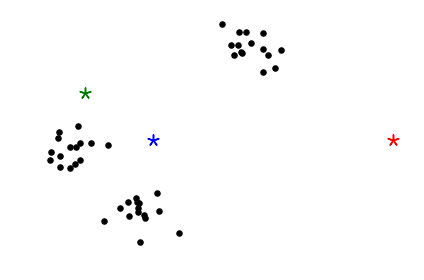

In [2]:
# create and load in data
blobs = datasets.make_blobs(n_samples=45, random_state=1)

# normalizing data so that all points fall within the unit square
# this is done for illustration purposes
X = unsuperlearnlib.K_means_methods.normalize_blobs(blobs)

# initialize centroids
C = np.array([[ 1,  .3,  .1],
              [.5,  .5,  .7]])

# plot data and initial centroids
unsuperlearnlib.K_means_methods.plot_data(X,C)

We now run K-means and animate centroid and assignment matrix updates at each iteration of the algorithm.

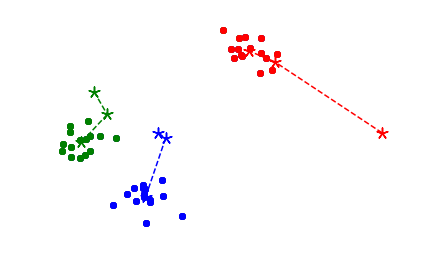

In [3]:
# run K-means
foo = unsuperlearnlib.K_means_methods.K_means_demo(X, C, mode='plot_the_steps')   

Everything worked well! Lets try a different centroid initialization this time.

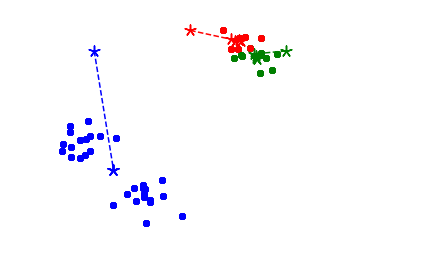

In [27]:
# a different centroid initialization
C = np.array([[ .4,  .1,  .7],
               [ 1,  .9,  .9]])

# run K-means
foo = unsuperlearnlib.K_means_methods.K_means_demo(X, C, mode='plot_the_steps')  

To avoid this issue, as with other non-convex problems, one should run K-means multiple times - each time initializing it differently - and pick the run that results in the lowest objective value.  

#### <span style="color:#a50e3e;">Example 2: </span> K-means and empty clusters

With random centroid initialization, it is possible for one or many of the clusters to end up empty, i.e., without any assigned data points, as you can see by activating the Python cell below.  

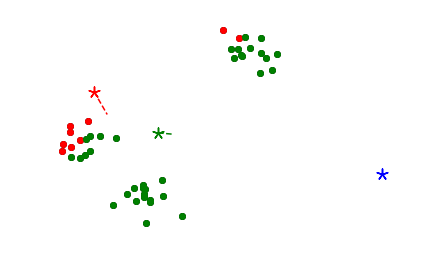

In [29]:
# centroid initialization
C = np.array([[ .1, 1, .3],
              [.7, .3, .5]])

# run K-means
foo = unsuperlearnlib.K_means_methods.K_means_demo(X, C, mode='plot_the_steps') 

Again, running K-means multiple times helps ameliorate this issue. Additionally, one can tweak the algorithm so that if one cluster ends up with no points, it is automatically assigned one of the points in the dataset at random. Alternatively one can initialize all cluster centroids in the beginning with actual data points selected at random from the dataset. 

## 1.4 The choice of K

As mentioned in the beginning of this post clustering is usually performed either to reduce the data dimension of large datasets, or to uncover underlying group structures in the data. In the former case, the choice of $K$ is determined by the size of the original dataset as well as the capacity of computational resources available at our disposal. In the latter case on the other hand, there is not much we can do without having knowledge/intuition about the correct number of clusters, but try different values for $K$ and compare the results. Unless in low dimensions, we cannot visually examine clustering results. Instead we can plot the objective value of K-means over a range of values for $K$, producing a so-called *scree plot*.  

#### <span style="color:#a50e3e;">Example 3: </span> Determining K using a scree plot

In the Python cell below we plot the K-means objective value for our blob dataset in the previous two Examples over $K=1,\ldots,10$.

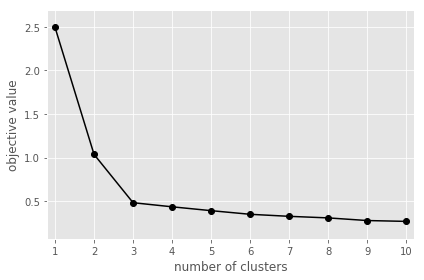

In [49]:
# scree plot
unsuperlearnlib.K_means_methods.scree_plot(X)

As one should expect, the objective value decreases monotonically as we increase $K$. Notice, the scree plot above has an *elbow* at $K=3$, meaning that increasing the number of clusters from $3$ to $4$ and onwards reduces the objective value by very little. Therefore one can argue - barring additional information about $K$  - that $K=3$ is a good choice for the number of clusters. 

<a id='endnotes'></a>
## References

[1] D’Haeseleer, P. How does gene expression clustering work? Nature Biotechnology. 23, 1499–1501, (2005).

[2] Eisen, M.B., Spellman, P.T., Brown, P.O. and Botstein, D. Cluster analysis and display of genome-wide expression patterns. Proc. Natl. Acad. Sci. USA 95, 14863–14868, (1998).